# Imports

In [193]:
!pip install gdown
!gdown 10Q8ZnFjJugBqSi95btaTQMP-mOz3Epzj
!gdown 10Qzd-TsUzYlf16dRxedygL5YvvJqSgcM

Downloading...
From (original): https://drive.google.com/uc?id=10Q8ZnFjJugBqSi95btaTQMP-mOz3Epzj
From (redirected): https://drive.google.com/uc?id=10Q8ZnFjJugBqSi95btaTQMP-mOz3Epzj&confirm=t&uuid=d76aaf6a-ed9a-4b12-8bc6-617dfcd569ca
To: /content/Normal_1.mat
100% 7.74M/7.74M [00:00<00:00, 115MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=10Qzd-TsUzYlf16dRxedygL5YvvJqSgcM
From (redirected): https://drive.google.com/uc?id=10Qzd-TsUzYlf16dRxedygL5YvvJqSgcM&confirm=t&uuid=2de41f47-9968-4edb-aff0-93ba6e927908
To: /content/IR007_1.mat
100% 2.93M/2.93M [00:00<00:00, 99.8MB/s]


In [488]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from  sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from scipy.io import loadmat
import pandas as pd
import numpy as np
import  scipy
import tqdm

In [489]:
# Load the .mat file
fault_mat = loadmat('/content/IR007_1.mat')
normal_mat = loadmat('/content/Normal_1.mat')

In [490]:
print(fault_mat.keys(),"\n")
print(normal_mat.keys())

dict_keys(['__header__', '__version__', '__globals__', 'X106_DE_time', 'X106_FE_time', 'X106_BA_time', 'X106RPM']) 

dict_keys(['__header__', '__version__', '__globals__', 'X098_DE_time', 'X098_FE_time'])


# Section2


## Data Selection

In [491]:
normal_data = normal_mat['X098_DE_time']
print(normal_data.shape)

fault_data = fault_mat['X106_DE_time']
print(fault_data.shape)

(483903, 1)
(121991, 1)


In [492]:
n_samples = 300
len_data = 200

normal_data_matrix = normal_data[:-(normal_data.shape[0] % len_data)].reshape(-1, len_data)
fault_data_matrix = fault_data[:-(fault_data.shape[0] % len_data)].reshape(-1, len_data)
print(normal_data_matrix.shape)
print(fault_data_matrix.shape)

normal_data_matrix = normal_data_matrix[:n_samples,:]
fault_data_matrix = fault_data_matrix[:n_samples,:]
print(normal_data_matrix.shape)
print(fault_data_matrix.shape)

(2419, 200)
(609, 200)
(300, 200)
(300, 200)


## Feature Extraction

In [493]:
def feature_extraction(data):
    features = {}

    # Standard Deviation
    features['Standard Deviation'] = np.std(data, axis=1)

    # Peak
    features['Peak'] = np.max(np.abs(data), axis=1)

    # Skewness
    features['Skewness'] = scipy.stats.skew(data, axis=1)

    # Kurtosis
    features['Kurtosis'] = scipy.stats.kurtosis(data, axis=1)

    # Crest Factor (peak divided by RMS)
    rms = np.sqrt(np.mean(np.square(data), axis=1))
    features['Crest Factor'] = features['Peak'] / rms

    # Clearance Factor (peak divided by the mean of the square root of the absolute values)
    features['Clearance Factor'] = features['Peak'] / np.mean(np.sqrt(np.abs(data)), axis=1)

    # Peak to Peak
    features['Peak to Peak'] = np.ptp(data, axis=1)

    # Shape Factor (RMS divided by the mean of the absolute values)
    features['Shape Factor'] = rms / np.mean(np.abs(data), axis=1)

    # Impact Factor (peak divided by mean)
    features['Impact Factor'] = features['Peak'] / np.mean(data, axis=1)

    # Square Mean Root (the square root of the mean of the squares)
    features['Square Mean Root'] = rms

    # Mean
    features['Mean'] = np.mean(data, axis=1)

    # Absolute Mean
    features['Absolute Mean'] = np.mean(np.abs(data), axis=1)

    # Root Mean Square
    features['Root Mean Square'] = rms

    # Impulse Factor (peak divided by the absolute mean)
    features['Impulse Factor'] = features['Peak'] / features['Absolute Mean']

    return features

In [516]:
normal_features = pd.DataFrame(feature_extraction(normal_data_matrix))
fault_features = pd.DataFrame(feature_extraction(fault_data_matrix))
normal_features['Label'] = 0
fault_features['Label'] = 1

selected_features = ['Standard Deviation', 'Peak', 'Skewness', 'Kurtosis', 'Crest Factor', 'Mean', 'Root Mean Square', 'Impulse Factor','Square Mean Root','Shape Factor','Label']

main_df = pd.concat([normal_features, fault_features], ignore_index=True)
df = main_df[selected_features]


## Shuffling and Split Dataset

In [517]:
df_shuffled = df.sample(frac=1).reset_index(drop=True)

X = df_shuffled.drop('Label', axis=1)
y = df_shuffled['Label']

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=53)
print(X_train_raw.shape, X_test_raw.shape, y_train.shape, y_test.shape)

(480, 10) (120, 10) (480,) (120,)


## Normalization

In [518]:
def min_max_normalization(data, max_val=None, min_val = None):
    if max_val is None:
        min_val = data.min()
        max_val = data.max()
    return (data - min_val) / (max_val - min_val), max_val, min_val

X_train, X_train_max, X_train_min = min_max_normalization(X_train_raw)
X_test, _, _ = min_max_normalization(X_test_raw,X_train_max,X_train_min)

# From Scratch Perceptron

In [519]:
class Perceptron:
    def __init__(self, input_size, learning_rate=0.01, loss_function='cross_entropy'):
        np.random.seed(53)
        self.weights = np.random.randn(input_size + 1)  # +1 for bias
        self.initial_learning_rate = learning_rate
        self.learning_rate = learning_rate
        self.loss_function = loss_function
        # Initialize lists to store metrics
        self.train_loss_list = []
        self.val_loss_list = []
        self.train_accuracy_list = []
        self.val_accuracy_list = []
        self.train_precision_list = []
        self.val_precision_list = []
        self.train_recall_list = []
        self.val_recall_list = []

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def predict(self, inputs):
        summation = np.dot(inputs, self.weights[1:]) + self.weights[0]
        return self.sigmoid(summation)

    def compute_loss(self, y_true, y_pred):
        y_pred = np.clip(y_pred, 1e-10, 1 - 1e-10)  # Avoid division by zero
        if self.loss_function == 'mse':
            return ((y_true - y_pred) ** 2).mean()
        elif self.loss_function == 'cross_entropy':
            return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        else:
            raise ValueError("Unsupported loss function")

    def compute_metrics(self, y_true, y_pred):
        y_pred_binary = y_pred >= 0.5
        TP = np.sum((y_true == 1) & (y_pred_binary == 1))
        TN = np.sum((y_true == 0) & (y_pred_binary == 0))
        FP = np.sum((y_true == 0) & (y_pred_binary == 1))
        FN = np.sum((y_true == 1) & (y_pred_binary == 0))

        precision = TP / (TP + FP) if TP + FP > 0 else 0
        recall = TP / (TP + FN) if TP + FN > 0 else 0
        accuracy = (TP + TN) / (TP + TN + FP + FN)

        return recall, precision, accuracy

    def fit(self, X, y, X_val, y_val, epochs=10, patience=2, batch_size=1):
        best_val_loss = np.inf
        patience_counter = 0
        batch_size = batch_size or X.shape[0]  # Default batch size is the entire dataset

        for epoch in range(epochs):
            # Shuffle and batch the dataset
            indices = np.arange(X.shape[0])
            np.random.seed(53)
            # np.random.shuffle(indices)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            for start_idx in range(0, X.shape[0], batch_size):
                end_idx = start_idx + batch_size
                X_batch = X_shuffled[start_idx:end_idx]
                y_batch = y_shuffled[start_idx:end_idx]

                predictions_batch = np.array([self.predict(x) for x in X_batch])
                errors = y_batch - predictions_batch

                # Update weights and bias for each batch
                for i in range(X_batch.shape[0]):
                    self.weights[1:] += self.learning_rate * errors[i] * X_batch[i]
                    self.weights[0] += self.learning_rate * errors[i]

            predictions_train = np.array([self.predict(x) for x in X])
            predictions_val = np.array([self.predict(x) for x in X_val])

            train_loss = self.compute_loss(y, predictions_train)
            val_loss = self.compute_loss(y_val, predictions_val)

            # Update metric lists
            self.train_loss_list.append(train_loss)
            self.val_loss_list.append(val_loss)

            train_recall, train_precision, train_accuracy = self.compute_metrics(y, predictions_train >= 0.5)
            self.train_accuracy_list.append(train_accuracy)
            self.train_precision_list.append(train_precision)
            self.train_recall_list.append(train_recall)

            val_recall, val_precision, val_accuracy = self.compute_metrics(y_val, predictions_val >= 0.5)
            self.val_accuracy_list.append(val_accuracy)
            self.val_precision_list.append(val_precision)
            self.val_recall_list.append(val_recall)


            print(f'Epoch {epoch+1}')

            # Check if validation loss improved
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1

            # Reduce learning rate if no improvement
            if patience_counter >= patience and self.learning_rate > 1e-10:
                self.learning_rate *= 0.5
                print(f'Reducing learning rate to {self.learning_rate}')
                patience_counter = 0


In [520]:
model_from_scratch = Perceptron(input_size=X_train.shape[1], learning_rate=0.01,loss_function="mse")
model_from_scratch.fit(X_train.to_numpy(),
                       y_train.to_numpy(),
                       X_test.to_numpy(),
                       y_test.to_numpy(),
                       epochs=50,
                       patience=5)

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50


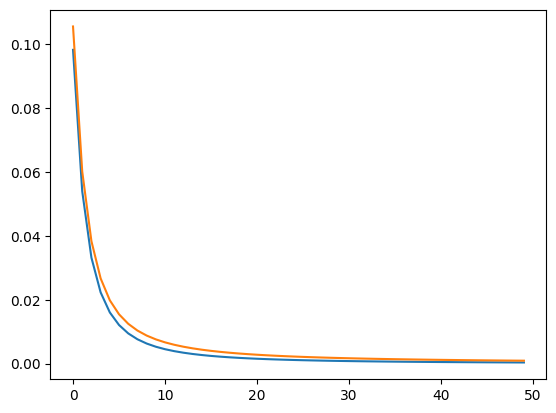

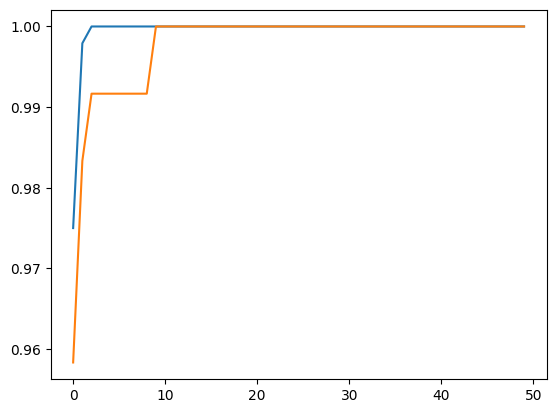

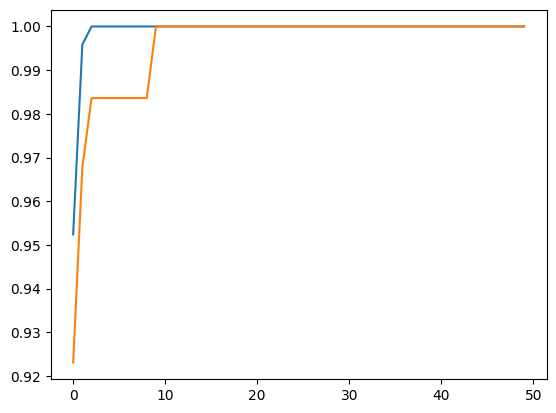

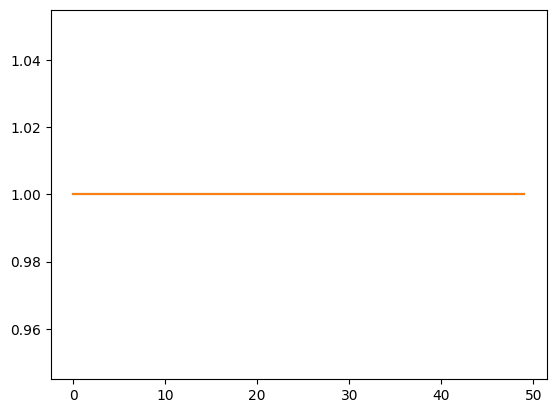

In [521]:
plt.plot(model_from_scratch.train_loss_list)
plt.plot(model_from_scratch.val_loss_list)
plt.show()
plt.plot(model_from_scratch.train_accuracy_list)
plt.plot(model_from_scratch.val_accuracy_list)
plt.show()
plt.plot(model_from_scratch.train_precision_list)
plt.plot(model_from_scratch.val_precision_list)
plt.show()
plt.plot(model_from_scratch.train_recall_list)
plt.plot(model_from_scratch.val_recall_list)
plt.show()

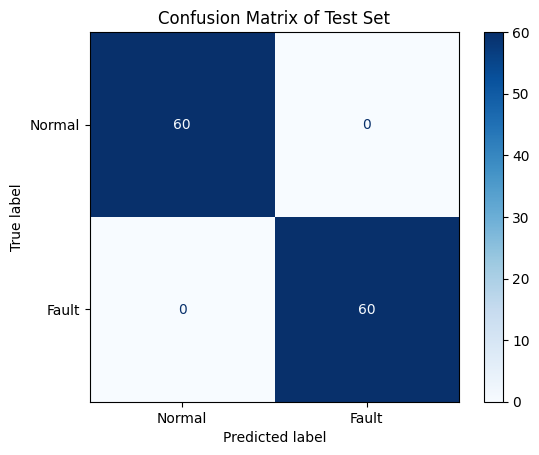

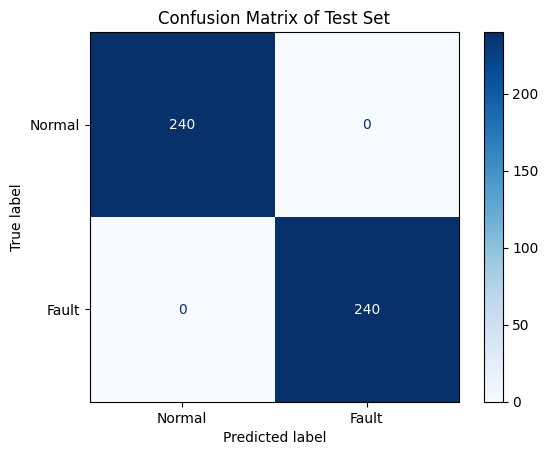

In [522]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model_from_scratch.predict(X_test.to_numpy(),)
y_pred = (y_pred > 0.5).astype(int)

# Calculating confusion matrix
cm = confusion_matrix(y_test.to_numpy(), y_pred)

# Plotting confusion matrix
labels = ['Normal', 'Fault']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix of Test Set')
plt.show()


y_pred = model_from_scratch.predict(X_train.to_numpy(),)
y_pred = (y_pred > 0.5).astype(int)

# Calculating confusion matrix
cm = confusion_matrix(y_train.to_numpy(), y_pred)

# Plotting confusion matrix
labels = ['Normal', 'Fault']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix of Test Set')
plt.show()

In [523]:
from sklearn.linear_model import SGDClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

perceptron = SGDClassifier(loss='perceptron', learning_rate='adaptive', eta0=0.01, random_state=53)

# Train the model
perceptron.fit(X_train, y_train)

# Make predictions
y_pred = perceptron.predict(X_test)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')


Accuracy: 1.0


In [533]:
from sklearn.linear_model import SGDClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, hinge_loss

model = SGDClassifier(loss='perceptron', learning_rate='adaptive', eta0=0.01, random_state=53)

loss_list=[]
recall_list=[]
precision_list = []
acc_list =[]

# Number of epochs
n_epochs = 100

# Training loop
for epoch in range(n_epochs):
    # Update the model with the current training data
    model.partial_fit(X_train, y_train, classes=np.unique(y_train))

    # Make predictions
    y_pred_train = model.predict(X_train)

    # Calculate accuracy, recall, and precision
    accuracy = accuracy_score(y_train, y_pred_train)
    recall = recall_score(y_train, y_pred_train, average='macro')
    precision = precision_score(y_train, y_pred_train, average='macro')

    # Calculate hinge loss
    # The decision function gives the distance of the samples to the hyperplane
    decision_scores = perceptron.decision_function(X_train)
    loss = hinge_loss(y_train, decision_scores)

    # Save the metrics
    acc_list.append(accuracy)
    recall_list.append(recall)
    precision_list.append(precision)
    loss_list.append(loss)



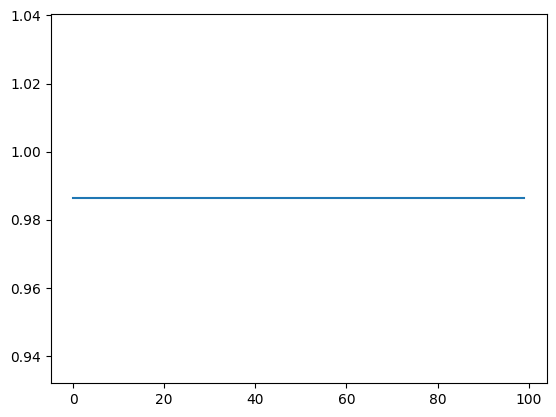

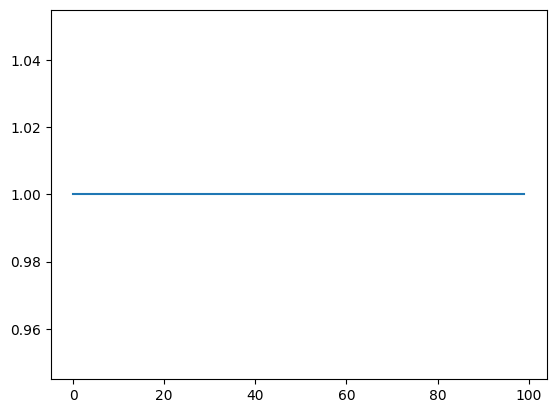

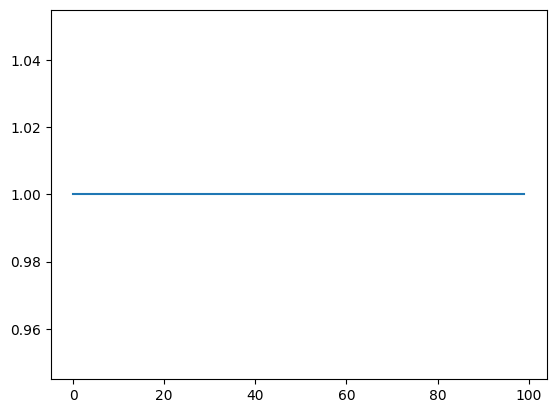

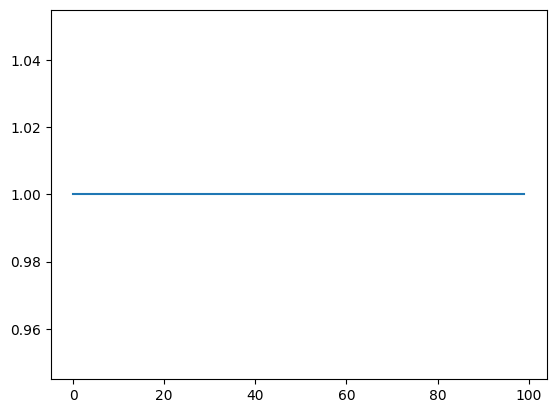

In [532]:
plt.plot(loss_list)
plt.show()
plt.plot(acc_list)
plt.show()
plt.plot(recall_list)
plt.show()
plt.plot(precision_list)
plt.show()